# Assignment 3
# Johannes M. Halkenhaeusser
# Minerva Schools at KGI
# CS146 - Prof. Sheffler
# Spring 2020


### Question 1 - Call Center 



In [0]:
import pystan
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
from google.colab import files
import random as rd
from scipy import stats

In [2]:
uploaded = files.upload()

Saving call_center.csv to call_center.csv


In [3]:
#taken from solution notebook

# Load the data set containing durations between calls arriving at the call center.
# All values are in minutes.
waiting_times_day = np.loadtxt('call_center.csv')
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Sum of data set:', sum(waiting_times_day))

# Split the data into 24 separate series, one for each hour of the day
current_time = 0
waiting_times_per_hour = [[] for _ in range(24)]  # Make 24 empty lists, one per hour
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

Size of data set: 5856
First 3 values in data set: [30.   3.4  3.2]
Sum of data set: 1441.6838153800093


In [0]:
#assemble stan code 

stan_code = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {
    int<lower=0> n;       // number of calls in the hour
    real<lower=0> waiting_times[n]; // waiting times (a list of items with length n)
    real<lower=0> prior_alpha;  // fixed prior hyperparameter
    real<lower=0> prior_beta;   // fixed prior hyperparameter
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {

    real lambda;  // the probability for a length of call
}

// The model block contains all probability distributions in the model.
model {
    lambda ~ gamma(prior_alpha, prior_beta);  // prior over lambda
    
     for(i in 1:n) {
        waiting_times[i] ~ exponential(lambda);  // likelihood function
    }
}
"""

In [5]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8f8083647295aa4a039d4117b0400769 NOW.


In [0]:
#define all the variables that have been specified in the 
#data part of the stan code

call_center_data = {
    'waiting_times': waiting_times_per_hour[13], #make sure to take hour 13
    'n': len(waiting_times_per_hour[13]),
    'prior_alpha': 1,
    'prior_beta': 0.25,
    }

In [0]:
#sample the posterior using stan
results_hour13 = stan_model.sampling(data=call_center_data)

In [0]:
#extract the samples over lambda
samples = results_hour13.extract()

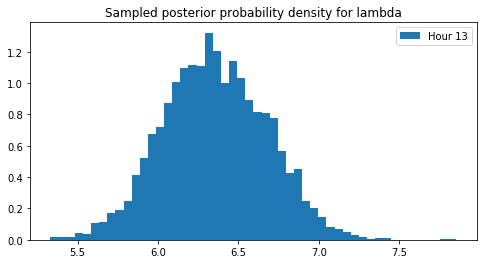

The 98% confidence interval from the Stan model is: [5.62382874 7.08704577]


In [29]:
#plot the histogram

plt.figure(figsize=(8,4))
plt.hist(samples['lambda'], bins=50, density=True, label='Hour 13')
plt.title('Sampled posterior probability density for lambda')
plt.legend()
plt.show()

#calculate the 98% confidence interval
print(f"The 98% confidence interval from the Stan model is: {np.percentile(samples['lambda'], (1,99))}")

The confidence interval matches the 98% confidence interval from the analytical solution (i.e., from 5.6 to 7.1).

### Question 2 - Normal likelihood with normal-inverse-gamma prior 

For this stan block we have to include more given hyperparameters because we not only need an alpha and beta but also muh and nu. 
We also change the data source to the data given by the second question.

In the parameter section we sample over the mean and the variance (because it is the variance and not the standard deviation given by the inverse gamma). 

In the model section we then follow the procedure laid out in the solutions: We first sample the variance (sigma_2) from the inverse gamma and the mean from a normal distribution with the standard deviation being sigma_2/prior_nu. 
Both parameters then get passed onto the likelihood function which is normally distributed around the sampled parameters. 

In [0]:
stan_code_2 = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {
    
    int<lower =0> n;            // length of data set
    
    real<lower=0>  prior_muh;   // prior mean
    real prior_nu;              // prior nuh
    real<lower=0> prior_alpha;  // fixed prior hyperparameter
    real<lower=0> prior_beta;   // fixed prior hyperparameter
    
    real data_q2[n];            // data source
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    real x;                 // to be estimated x
    real sigma_2; // variance to be estimated
}

// The model block contains all probability distributions in the model.
model {
    sigma_2 ~ inv_gamma(prior_alpha, prior_beta);  
    x ~ normal(prior_muh, sqrt(sigma_2/prior_nu));  
    data_q2 ~ normal(x, sqrt(sigma_2));             // Normal likelihood
}
"""

In [11]:
#compile the model
stan_model_2 = pystan.StanModel(model_code=stan_code_2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d97f97a6c69a8f0fd1c50623327333ef NOW.


In [0]:
### From Solutions Gist:

#the data
data_q2 =[3.54551763569501, 4.23799861761927, 4.72138425951628, -0.692265320368236, 3.04473513808788, 3.10721270732507, 3.42982225852764, 3.12153903971176, 3.60532628639808, 2.46561737557325, 1.64059465916131, 2.4621623937158, 2.76744495617481, 2.11580054750407, 5.14077208608354, 4.90288499104252, 1.43357579078348, 4.78997817363558, 1.93633438207439, 2.43698838097178, 3.95389148701877, 2.4242295507716, 2.90256268679023, 2.90931728045901, 0.658072819386888, 3.05946763895983, 3.42615331539605, 2.68842833004417, 2.35850130765166, 2.20014998540933, 4.73846511350084, 4.19839721414451, 2.11805510171691, -0.572742936038015, 0.389413982010623, 3.87846130744249, 1.34057656890858, 0.7235748351719, 5.11042369840174, 4.00747556696571, 3.18080956726965, 3.24677964069676, 5.1154659863626, 1.80276616697155, 0.305877679021404, -0.449168307882718, 4.63705561194774, 1.37783714058301, 4.9608149859515, 6.7764195802069, 1.75515522922399, 7.04457337435215, 0.625185284955128, 2.25130734369064, 2.19770178119255, 2.16858257249432, 6.25367644481438, 0.116081323476489, 2.06315857864341, 1.82409781471718, 5.15226741230987, 2.03408231293173, -1.12450854337596, 5.03511270642234, 2.03841989653263, 5.80911741751597, 2.31718128783245, 4.97575010580997, 3.34262752222776, -0.786983904253601, 0.777362359850013, 0.975825009321195, 3.76354577515958, 7.27215002907876, 1.35404089480189, 3.76567940257157, 3.48573993343334, 1.85976988586156, 1.93567061960716, 5.31071812003942, 2.96832987672751, 3.32378908637275, 2.61631960054551, 5.80897964052825, 4.95215217171488, 1.32036772796131, 3.79932542233371, 3.08108492766309, 2.6734110081666, -0.14251851138521, 2.48744375588965, 3.98463042123415, 6.32781680028, 4.0029172024315, 4.23210369459457, 1.71412938967325, 5.16492114963802, 2.53409673107906, 4.77346963973334, 3.34088878725551, 4.77681472750664, 3.81135755590976, 1.14054269983137, 1.42057452397702, 0.132142311125433, 7.12577254064672, 4.85422012781764, 4.15745720676399, 4.48763147363348, 1.56060322283629, 2.64821761542887, 1.26655351354548, 4.48497722937931, 4.3286302403783, 4.26157679512625, 4.0597558651364, 5.14051109132496, 2.5660348362221, 1.10764013818617, 0.386889523012303, 3.54150473246237, 3.57480214382351, 1.95150869584847, 2.70688970563118, 2.47971849820016, 6.50838037000679, 4.01511556826974, 1.11562740835344, 5.02637639472439, 4.38184491686864, 5.60423144047386, 2.40067408379298, 5.7849941378344, 2.37225791084559, 6.86031465910273, 4.09214858239736, 6.85994063692621, 3.62202415158781, -1.11220646958158, 3.73920971696866, 3.24533871512216, 1.28724203643002, 0.291152541773164, 0.368630935755111, 6.71607270510525, 5.42278455200833, 5.35188416119281, 2.305874586163, -1.85878097203032, 2.69877382351447, 4.84121860550417, 4.40973060799391, 5.04399320650774, 2.68632252661298, 6.06531610659912, 3.11881325011993, 3.45532087005125, 3.08442259840346, 4.43564424136733, 2.84252623135804, 1.50536798885106, 1.48868622407603, 2.07322837615663, 2.5476910210998, 5.66941808257884, 2.16731067416426, 2.49843958833905, 3.94586413879977, 0.316433764679541, -0.608937441815983, 2.5943436558557, 1.05516869528337, 2.1447601332725, 6.65846634141906, 2.1771555267834, 5.23953812029442, 3.53629759842647, 6.03263538017003, 3.85739159396599, 5.95093453004638, 1.12856987160476, 3.5559912886093, 2.21974864244489, 3.38471394882135, -1.90805399279409, 3.5113699258973, 4.49319955412346, 5.10507952638867, 1.08277895384184, 4.58403638422759, 1.37304994426824, 4.17566975753523, 3.36454182510378, 0.177136582644021, 2.91337423388405, 3.22796455457526, 2.80124198378441, 1.95189718582788, 3.37659263896246, -1.6463045238231]

#the prior hyperparameters
mu_0 = 0        # The prior mean is centered around 0.
nu_0 = 0.054    # The smaller nu_0 is, the more uncertain we are about the prior mean.
alpha_0 = 1.12  # alpha and beta govern the marginal prior over the variance.
beta_0 = 0.4

#formatting the data to suit the stan model 
data_q_2 = {
    'data_q2': data_q2,
    'n': len(data_q2),
    'prior_muh': 0,        # The prior mean is centered around 0.
    'prior_nu': 0.054,    # The smaller nu_0 is, the more uncertain we are about the prior mean.
    'prior_alpha': 1.12,  # alpha and beta govern the marginal prior over the variance.
    'prior_beta': 0.4,
}

In [0]:
#sample results
results_question2 = stan_model_2.sampling(data=data_q_2)

In [0]:
#extract the samples
samples_2 = results_question2.extract()

95% prior confidence intervals:
x: [2.805, 3.340]
σ²: [2.961, 4.457]


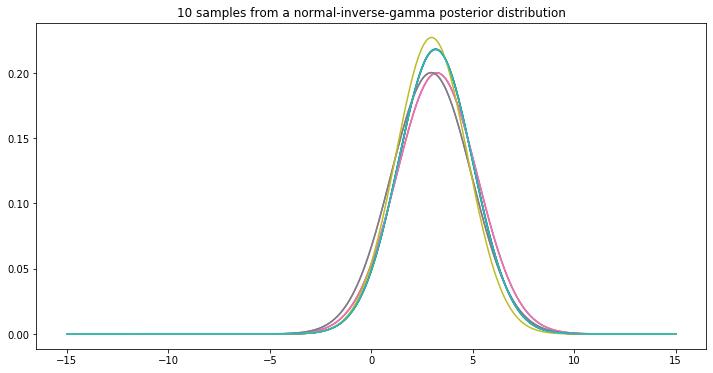

In [30]:
## adapting the code from the solution gist

# Estimate 95% posterior confidence intervals for the mean x and variance σ² of the data

print('95% prior confidence intervals:')
print('x: [%.3f, %.3f]' % (
    np.percentile(samples_2['x'],(2.5)),
    np.percentile(samples_2['x'],(97.5))))
print('σ²: [%.3f, %.3f]' % (
    np.percentile(samples_2['sigma_2'],(2.5)),
    np.percentile(samples_2['sigma_2'],(97.5))))

# Generate 10 samples from the posterior
num_samples = 10

# Plot the normal distributions corresponding to the samples
plt.figure(figsize=(12, 6))
plot_x = np.linspace(-15, 15, 500)
for i in range(num_samples):
    
    sample_index = rd.randint(0, len(samples_2))

    plot_y = stats.norm.pdf(plot_x, loc=samples_2['x'][sample_index], scale=np.sqrt(samples_2['sigma_2'][sample_index]))
    plt.plot(plot_x, plot_y)
plt.title('%i samples from a normal-inverse-gamma posterior distribution' % num_samples)
plt.show()

The result is as we expected and the confidence intervals match the solutions notebook.

### Question 3 Log-normal HRTEM data
Normal likelihood log-transformed data and using a normal-inverse-gamma prior.

This works the same as the previous model, just that this time, the data is logged before it is fed into the model. Technically we do not have to recompile the stan model again, but I did for sake of clarity. 

We will use the logged data and feed it into the model. When fitting the samples of the posterior over the model we will have to transform out of log-space into the regular scale. 

In [0]:
stan_code_hrtem = """

data {
    
    int<lower =0> n;            // length of data set
    
    real<lower=0>  prior_muh;   // prior mean
    real prior_nu;              // prior nuh
    real<lower=0> prior_alpha;  // fixed prior hyperparameter
    real<lower=0> prior_beta;   // fixed prior hyperparameter
    
    real logged_data[n];            // data source
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    real x;                 // to be estimated x
    real sigma_2; // variance to be estimated
}

// The model block contains all probability distributions in the model.
model {
    sigma_2 ~ inv_gamma(prior_alpha, prior_beta);  
    x ~ normal(prior_muh, sqrt(sigma_2/prior_nu)); 
    logged_data ~ normal(x, sqrt(sigma_2));
}
"""

In [18]:
stan_model_hrtem = pystan.StanModel(model_code=stan_code_hrtem)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e3a010011d5d2c6a9f41208872dccbde NOW.


In [21]:
uploaded = files.upload()

Saving hrtem.csv to hrtem (1).csv


In [0]:
hrtem_data = np.loadtxt('hrtem.csv')

In [0]:
log_data = np.log(hrtem_data)

In [0]:
#using hyperparameters from solutions notebook

data_hrtem = {
    'logged_data': log_data,
    'n': len(log_data),
    'prior_muh': 2.3,
    'prior_nu': 0.1,
    'prior_alpha': 2,    
    'prior_beta': 5,
}

In [0]:
results_hrtem = stan_model_hrtem.sampling(data=data_hrtem)
samples_hrtem = results_hrtem.extract()

95% prior confidence intervals:
x: [1.834, 1.954]
σ²: [0.438, 0.563]


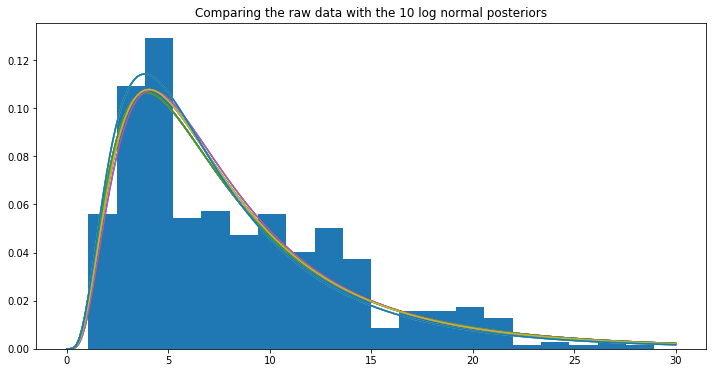

In [31]:
## adapting the code from the solution gist

# Estimate 95% posterior confidence intervals for the mean x and variance σ² of the data

print('95% prior confidence intervals:')
print('x: [%.3f, %.3f]' % (
    np.percentile(samples_hrtem['x'],(2.5)),
    np.percentile(samples_hrtem['x'],(97.5))))
print('σ²: [%.3f, %.3f]' % (
    np.percentile(samples_hrtem['sigma_2'],(2.5)),
    np.percentile(samples_hrtem['sigma_2'],(97.5))))


# Generate 10 samples from the posterior
num_samples = 10

# Plot the normal distributions corresponding to the samples
plt.figure(figsize=(12, 6))
plt.hist(hrtem_data, bins=20, density = True)
plot_x = np.linspace(0, 30, 200)
for i in range(num_samples):
    sample_index = rd.randint(0, len(samples_hrtem))
    plot_y = stats.lognorm.pdf(plot_x, np.sqrt(samples_hrtem['sigma_2'][sample_index]), scale = np.exp(samples_hrtem['x'][sample_index]))
    plt.plot(plot_x, plot_y)
    plt.plot(plot_x, plot_y)
plt.title('Comparing the raw data with the %i log normal posteriors' % num_samples)
plt.show()


The graph matches the expectation that the posterior when transformed back into normal scale should fit over the raw data. 

The confidence intervals fit the solution notebook.